In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as la
import scipy.sparse as sparse
from matplotlib import cm
import timeit
import numba
from numba import jit
from iteration_methods import*

In [2]:
#output settings
np.set_printoptions(precision=2)
# %matplotlib qt 

In [3]:
#Define analytical solution and source term
def u_analytical(x, y):

    uan = np.sin(np.pi*x)*np.sin(np.pi*y) + x

    return uan

def source(x, y):

    f = -2*np.pi**2*np.sin(np.pi*x)*np.sin(np.pi*y)

    return f

In [4]:
#Set up the grid

Nx = 100                 #Number of grid points
Ny = 100

x_I, x_F = 0, 1         #start and end points           
y_I, y_F = 0, 1

X = np.linspace(x_I, x_F, Nx+1)         #1d grids in each dirrection        
Y = np.linspace(y_I, y_F, Ny+1)

dx = (x_F - x_I)/Nx
dy = (y_F - y_I)/Ny

x, y = np.meshgrid(X, Y)            #2d meshgrid

In [5]:
#Setup the parameters for the solver

f = source(x, y)                                #source term

u_guess = np.cos(np.pi*x)*np.cos(np.pi*y)       #initial guess

boundary = ((0,1), (X, X))                     #dirichlet boundary conditions


iterations = 2000000
tolerance = 1.e-8

omega_opt = 2/(1+np.sin(np.pi*max(dx, dy)))                                    #relaxation parameter for SOR method

In [6]:
jitted_jacobi = jit(nopython=True)(slow_jacobi)
SOR = jit(nopython=True)(SOR)
a, b, c, d = jitted_jacobi(np.eye(Nx), f, (x, y), init_guess=None, boundary=boundary,                                                                            tolerance=tolerance, itermax=1)
a, b, c, d = SOR(np.eye(Nx), f, (x, y), init_guess=None, boundary=boundary,                                                                            tolerance=tolerance, itermax=1)
del a, b, c, d

In [12]:
#Calculate the results, time them and print output
#The numpy version of jacobi method
start = timeit.default_timer()

u_np, k_np, rel_diff_np, conv_hist_np = numpy_jacobi(np.eye(Nx), f, (x, y), init_guess=u_guess, boundary=boundary,                                                                         tolerance=tolerance, itermax=iterations)

elapsed_np = timeit.default_timer() - start

print('Numpy Jacobi \nNumber of iterations: {:} \nRelative difference: {:1.4E} \nElapsed time: {:1.2E}s'.format(k_np, rel_diff_np,                                                                                                                    elapsed_np))
print('-'*50)

#------------------------------------------------
#The jitted version of jacobi method
start = timeit.default_timer()

u_jit, k_jit, rel_diff_jit, conv_hist_jit = jitted_jacobi(np.eye(Nx), f, (x, y), init_guess=u_guess, boundary=boundary,                                                                            tolerance=tolerance, itermax=iterations)

elapsed_jit = timeit.default_timer() - start

print('Jitted Jacobi \nNumber of iterations: {:} \nRelative difference: {:1.4E} \nElapsed time: {:1.2E}s'.format(k_jit, rel_diff_jit,                                                                                                                elapsed_jit))
print('-'*50)
#-----------------------------------------------
#The jitted Gauss-Seidel method (or sor method with omega=1)
start = timeit.default_timer()

u_gs, k_gs, rel_diff_gs, conv_hist_gs = SOR(np.eye(Nx), f, (x, y), init_guess=u_guess, boundary=boundary,                                                                         tolerance=tolerance, itermax=iterations, omega=1)

elapsed_gs = timeit.default_timer() - start

print('Gauss-Seidel \nNumber of iterations: {:} \nRelative difference: {:1.4E} \nElapsed time: {:1.2E}s'.format(k_gs, rel_diff_gs,                                                                                                                elapsed_gs))
print('-'*50)

#------------------------------------------------
#The sor method with an arbitrary value of omega (=1.5)
start = timeit.default_timer()

u_sor, k_sor, rel_diff_sor, conv_hist_sor = SOR(np.eye(Nx), f, (x, y), init_guess=u_guess, boundary=boundary,                                                                         tolerance=tolerance, itermax=iterations, omega=1.8)

elapsed_sor = timeit.default_timer() - start

print('SOR omega = {:} \nNumber of iterations: {:} \nRelative difference: {:1.4E}'
      ' \nElapsed time: {:1.2E}s'.format(1.5, k_sor, rel_diff_sor, elapsed_sor))
print('-'*50)

#------------------------------------------------
#The sor method with the optimum value of omega (=2/(1+sin(pi*max(dx, dy))))
start = timeit.default_timer()

u_sor_opt, k_sor_opt, rel_diff_sor_opt, conv_hist_sor_opt = SOR(np.eye(Nx), f, (x, y), init_guess=u_guess, boundary=boundary,                                                                         tolerance=tolerance, itermax=iterations, omega=omega_opt)

elapsed_sor_opt = timeit.default_timer() - start

print('SOR omega = {:} \nNumber of iterations: {:} \nRelative difference: {:1.4E}'
      ' \nElapsed time: {:1.2E}s'.format(omega_opt, k_sor_opt, rel_diff_sor_opt, elapsed_sor_opt))
print('-'*50)

#------------------------------------------------
#The straightforward slow jacobi version, for comparison
# start = timeit.default_timer()

# u_slow, k_slow, rel_diff_slow, conv_hist_slow = slow_jacobi(np.eye(Nx), f, (x, y), init_guess=u_guess, boundary=boundary,                                                                         tolerance=tolerance, itermax=iterations)

# elapsed_slow = timeit.default_timer() - start

# print('Slow Jacobi \nNumber of iterations: {:} \nRelative difference: {:1.4E} \nElapsed time: {:1.2E}s'.format(k_slow, rel_diff_slow,                                                                                                                elapsed_slow))
# print('-'*50)
#------------------------------------------------


Numpy Jacobi 
Number of iterations: 21698 
Relative difference: 9.9974E-09 
Elapsed time: 4.78E+00s
--------------------------------------------------
Jitted Jacobi 
Number of iterations: 21698 
Relative difference: 9.9974E-09 
Elapsed time: 8.87E-01s
--------------------------------------------------
Gauss-Seidel 
Number of iterations: 11559 
Relative difference: 9.9915E-09 
Elapsed time: 1.80E+00s
--------------------------------------------------
SOR omega = 1.5 
Number of iterations: 1514 
Relative difference: 9.9241E-09 
Elapsed time: 2.29E-01s
--------------------------------------------------
SOR omega = 1.9390916590666494 
Number of iterations: 313 
Relative difference: 9.6018E-09 
Elapsed time: 4.75E-02s
--------------------------------------------------


In [8]:
# time_np = %timeit -o numpy_jacobi(np.eye(Nx), f, (x, y), init_guess=u_guess, boundary=boundary,                                                                         tolerance=tolerance, itermax=iterations)

# time_jit = %timeit -o jitted_jacobi(np.eye(Nx), f, (x, y), init_guess=u_guess, boundary=boundary,                                                                         tolerance=tolerance, itermax=iterations)

# time_gs = %timeit -o SOR(np.eye(Nx), f, (x, y), init_guess=u_guess, boundary=boundary,                                                                         tolerance=tolerance, itermax=iterations, omega=1)

# time_sor = %timeit -o SOR(np.eye(Nx), f, (x, y), init_guess=u_guess, boundary=boundary,                                                                         tolerance=tolerance, itermax=iterations, omega=1.8)

# time_sor_opt = %timeit -o SOR(np.eye(Nx), f, (x, y), init_guess=u_guess, boundary=boundary,                                                                         tolerance=tolerance, itermax=iterations, omega=omega_opt)

In [9]:
#Compare with analytical solution and verify that all versions produce the same results

u_an = u_analytical(x, y)

error_np = la.norm(u_np - u_an, 2)/la.norm(u_an, 2)
error_jit = la.norm(u_jit - u_an, 2)/la.norm(u_an, 2)
# error_slow = la.norm(u_slow - u_an, 2)/la.norm(u_an, 2)
error_gs = la.norm(u_gs - u_an, 2)/la.norm(u_an, 2)
error_sor = la.norm(u_sor - u_an, 2)/la.norm(u_an, 2)

print('Numpy jacobi error: {:1.4E} \n'.format(error_np))
print('Jitted jacobi error: {:1.4E} \n'.format(error_jit)) 
# print('Slow jacobi error: {:1.4E} \n'.format(error_slow))                                                                     
print('Gauss-Seidel error: {:1.4E} \n'.format(error_gs))                                                                             
print('SOR error: {:1.4E} \n'.format(error_sor))                                                                             

Numpy jacobi error: 2.1009E-05 

Jitted jacobi error: 2.1009E-05 

Gauss-Seidel error: 3.1179E-05 

SOR error: 4.0244E-05 



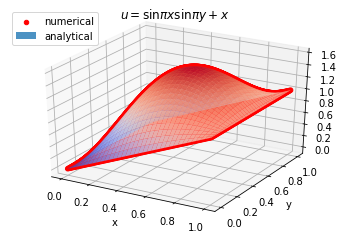

In [10]:
#Plot and compare the results

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

#plot just one of the versions
scat = ax.scatter(x, y, u_sor_opt, c = 'r', label = 'numerical', alpha = 1)
surf = ax.plot_surface(x, y, u_an, cmap = cm.coolwarm, label = 'analytical', alpha = 0.8)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('$u = \sin\pi x \sin\pi y + x$')

surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
ax.legend(loc = 2)
plt.show()

In [11]:
%matplotlib qt

fig, ax = plt.subplots()

ax.plot(conv_hist_jit, label='jacobi')
ax.plot(conv_hist_gs, label='gauss-seidel')
ax.plot(conv_hist_sor, label='sor ($\omega={:1.2}$)'.format(1.8))
ax.plot(conv_hist_sor_opt, label='optimum sor ($\omega={:1.2}$)'.format(omega_opt))

ax.set_xlabel('iteration')
ax.set_ylabel('$\\frac{||u^{(k+1)}-u^{(k)}||_2}{||u^{(k)}||_2}$', rotation='horizontal')
ax.yaxis.labelpad = 0

ax.set_title('Convergence rate')

ax.set_yscale('log')

ax.legend()